In [69]:
import os
import time

import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image 
from matplotlib.patches import Patch

In [70]:
def read_picture(file_root='cube_20221019_091444'):
    image_files = glob.glob(f'{file_root}/pre_process/*.png')
    image_files.sort()
    # 读取图片
    image_list = []
    for file in image_files:
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # 以灰度模式读取图片
        image_list.append(image)
    # 将图片转换为NumPy数组
    image_array = np.array(image_list)
    return image_array, image_array

In [108]:
def read_picture(file_root='cube_20221019_091444'):
    # 图片文件夹路径
    current_path = os.getcwd()
    folder_path = os.path.join(file_root,'pre_process')
    
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(".png")]
    image_files.sort()

    # 读取图片
    image_list = []
    for filename in image_files:
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 以灰度模式读取图片
            image_list.append(image)

    # 将图片转换为NumPy数组
    image_array = np.array(image_list)

    return image_array, image_array

In [109]:
def generate_img(image, img, reshaped_labels):

    # 读取灰度图像
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # edges = cv2.Canny(image, 20, 100)
    image = np.uint8(image)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    show_image = np.zeros((3, image.shape[0], image.shape[1]))
    temp_image = np.zeros((1, image.shape[0], image.shape[1]))
    # 遍历每个轮廓，生成小图片
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
       # 提取小图片
        if w>=30 and h>=30:
            object_image = img[:, y:y+h, x:x+w]
            object_image = object_image.transpose(1, 2, 0)
            h, w = object_image.shape[0], object_image.shape[1]
            if h <250 and w < 250:
                # data = cv2.copyMakeBorder(img, top_size, bottom_size, left_size, right_size, cv2.BORDER_CONSTANT)
                object_image = cv2.copyMakeBorder(object_image, 0, 250-h, 0, 250-w, cv2.BORDER_CONSTANT)
#             plt.figure()
#             plt.imshow(object_image[:,:,0])
            object_image = cv2.resize(object_image, (250, 250))
            # object_image = cv2.resize(object_image, (1000, 200))
            object_image = object_image.transpose(2, 0, 1)
            object_image = object_image /50
            # print('_____________ ___________')
            # print(object_image.shape)
            # object_image = object_image[:,:,:]

            object_image = torch.tensor(object_image)
            label = model_predict(object_image.to(torch.float32))
            # print(label)
            temp_image[:,y:y+h, x:x+w] = int(label) + 1
            # print(np.count_nonzero(temp_image[0] == 2))
            
            
    # 第一类赋值为255
    show_image[0][reshaped_labels[0] == 0] = 0  
    # 第二类赋值为255
    show_image[1][np.logical_and(reshaped_labels[0] == 1, temp_image[0] == 1)] = 255
    # 第三类赋值为255
    show_image[2][np.logical_and(reshaped_labels[0] == 1, temp_image[0] == 2)] = 255
    show_image[0][np.logical_and(reshaped_labels[0] == 1, temp_image[0] == 3)] = 255
    
    show_image = np.transpose(show_image, (1, 2, 0)).astype(np.uint8)
    return show_image



In [132]:
class CustomResNet152(nn.Module):
    def __init__(self, num_classes=3, input_channels=13):
        super(CustomResNet152, self).__init__()
        resnet152 = models.resnet18(pretrained=False)  
        resnet152.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = nn.Sequential(*list(resnet152.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
model = CustomResNet152(num_classes=3,input_channels=13)

In [138]:

def model_predict(image):
    """
    返回类别
    :param image: numpy格式的图片数组
    :return: 类别（格式为整数）
    """    
    model = CustomResNet152(num_classes=2, input_channels=13)
    model.load_state_dict(torch.load('a.pt', map_location='cpu'))
    # model.load_state_dict(torch.load('best.pt'))
    # model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    model.eval()
    # object_image = Image.fromarray(image)
    # image = transform(object_image)
    image = image.unsqueeze(0)
    # print('----------- shape ------------')
#     plt.figure()
#     plt.imshow(image[0,2,:,:])
    # image = image[:,:,:3]
    # image = image.repeat(1, 3, 1, 1)
    outputs = model(image)
    print(outputs.data)
    _, predicted = torch.max(outputs.data, 1)

    return predicted.item()


In [145]:
from gx_spectral.feature import roi
def main(file_name, title='1 and 2'):
    # 获取测试集路径
    
    # root = os.path.join(file_name, 'pre_process')
    root = file_name
    
    image, img = read_picture(file_root=root)
    # image, reshaped_labels = KmCluster(image)
    mask = roi.seg_thresh(image[5,:,:],60,1, cv.THRESH_BINARY)
#     image = image[3,:,:]
#     thredshold = 55
#     image[image<=thredshold] = 0
#     image[image>thredshold] = 1
#     mask = image
    # mask = mask.transpose(1, 0)
    print(mask.shape)

    plt.figure()
    plt.imshow(mask)
    show_image = generate_img(mask, img, [mask])
    fig, ax = plt.subplots()
    legend_elements = [
        Patch(facecolor='green', edgecolor='blue', label='1'),
        Patch(facecolor='blue', edgecolor='green', label='2'),
        Patch(facecolor='red', edgecolor='red', label='3')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.imshow(show_image)
    plt.title(title)
    plt.show()
    

(1311, 2021)
tensor([[ 1.3404, -1.6694]])
tensor([[ 0.8979, -1.3656]])
tensor([[ 0.4532, -0.9837]])
tensor([[ 0.5206, -1.0000]])
tensor([[ 0.6657, -1.1405]])
tensor([[ 0.5657, -0.9839]])
tensor([[ 1.7139, -2.0148]])
tensor([[-0.2279, -0.4724]])
tensor([[ 0.2816, -0.8013]])
tensor([[ 0.4533, -0.9600]])
tensor([[-0.5737, -0.1665]])
tensor([[ 0.3865, -0.9297]])
tensor([[-0.7485, -0.0336]])
tensor([[ 0.7559, -1.1607]])
tensor([[ 1.3465, -1.7808]])


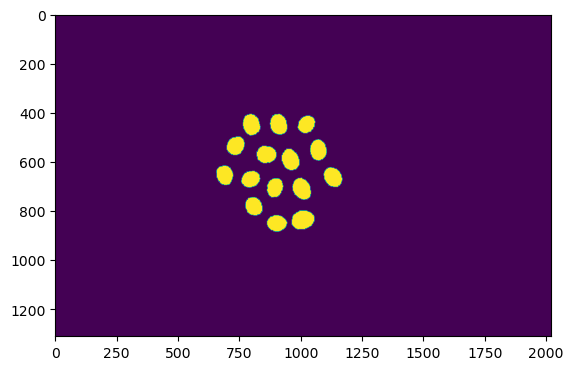

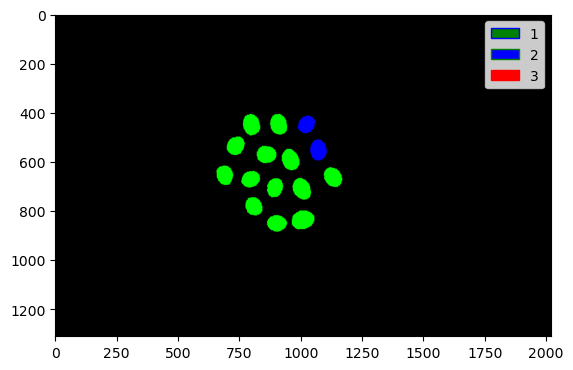

In [146]:
import glob
import cv2 as cv

if __name__ == '__main__':
    #model.load_state_dict(torch.load('best.pt'))
    #model.eval()
    file = r'D:\mycodes\RITH\coffe\datas\1205-2\test\mix\123_20231205_180326'
    root = r'C:\Users\jerem\Desktop\hwb\data\coffee_bean\data2023.12.21\test'
    root = r'D:\mycodes\RITH\coffe\datas\data202312271\1\1_20231228_111620'
    #root = r'D:\mycodes\RITH\coffe\datas\data202312271\2\2_20231228_103342'
    main(file_name=root, title='')

    # file = r'C:\Users\jerem\Desktop\hwb\data\coffee_bean\data2023.12.21\test\mix\12_20231221_171246'
    # main(file_name=file, title='')
